[View in Colaboratory](https://colab.research.google.com/github/camiloyatet/Curso-DeepLearning/blob/master/MIIA_Project3.ipynb)

<img src="https://image.ibb.co/no3BeJ/Header1.png" alt="Header1" border="0">



---



# Initializing session

The following code section allows to use Google Drive account as the storage unit in order to load the datasets for further analysis.

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
!pip install livelossplot # Install new packages
!pip install tqdm

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

Setting up iso-codes (3.75-1) ...
Setting up distro-info-data (0.36ubuntu0.2) ...
Setting up python-pycurl (7.43.0-2build2) ...
Setting up lsb-release (9.20160110ubuntu5) ...
Setting up libgirepository-1.0-1:amd64 (1.54.1-1) ...
Setting up libkmod2:amd64 (24-1ubuntu2) ...
Setting up gir1.2-glib-2.0:amd64 (1.54.1-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arg

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 2.3MB/s 
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# **Loading information**

### Images

In order to apply transfer learning with VGG16 model, we predict the output of the last layer (ignoring the last layer of the original model which has an 1.000 shape output).

We previously procesed the image to transform it into an array object. click [here](https://github.com/nlozadah/Curso-DeepLearning/blob/master/Proyecto1/Proccesing%20images.ipynb) to see the proccess


In [0]:
#Files in drive
print('Files in Drive:')
!ls drive/Python/Proyecto_final

Files in Drive:
20180717_images_gris_test_.txt	 images_resize_gray
20180717_images_gris_train_.txt  images_testing_gray.txt
dataTesting.csv			 images_training_gray.txt
dataTraining.csv		 testing_color_160.txt
images_gris_test_forma_2.txt	 training_color_160.txt
images_gris_train_forma_2.txt


Loading train color images in shape (,5,5,512)

In [0]:
import pickle

 
with open("drive/Python/Proyecto_final/training_color_160.txt", "rb") as fp:   # Unpickling
   images_training_color = pickle.load(fp)

Loading test color images in shape (,5,5,512)

In [0]:
import pickle
 
with open("drive/Python/Proyecto_final/testing_color_160.txt", "rb") as fp:   # Unpickling
   images_testing_color = pickle.load(fp)

In [0]:
print(images_training_color.shape)
print(images_testing_color.shape)

(7895, 5, 5, 512)
(3383, 5, 5, 512)


### Text

Now we load the text information, this files also have the category of each movie in training data set

In [0]:
path = 'drive/Python/Proyecto_final'
dataTraining = pd.read_csv(os.path.join(path, '', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, '', 'dataTesting.csv'), encoding='UTF-8', index_col=0)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

# Maching learning Models

### For images

Loading black and white images. We apply a Flatten so the shape of the final file is (x, 40960). to see the code tha proccess this images click [here](https://github.com/albahnsen/AppliedDeepLearningClass/blob/master/finalProject/ExampleImgRF.ipynb)

In [0]:
import pickle

with open("drive/Python/Proyecto_final/images_training_gray.txt", "rb") as fp:   # Unpickling
   images_training_gray_planas = pickle.load(fp)

In [0]:
with open("drive/Python/Proyecto_final/images_testing_gray.txt", "rb") as fp:   # Unpickling
   images_testing_gray_planas = pickle.load(fp)

In [0]:
print(images_training_gray_planas.shape,images_testing_gray_planas.shape)

(7895, 40960) (3383, 40960)


### Principal Component Analysis

We apply PCA to reduce the dimension of the features, only keep the first 32 principal components

In [0]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_training_gray_planas)

In [0]:
images_testing_pca = pca.transform(images_testing_gray_planas)

Split train and test from de training dataset where *Y* is known

In [0]:
X_train_pca, X_test_pca, y_train_genres_pca, y_test_genres_pca = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

### Random Forest Classifier

In [0]:
clf_RF = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf_RF.fit(X_train_pca, y_train_genres_pca)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

### Model's Performance Evaluation

In [0]:
y_pred_genres = clf_RF.predict_proba(X_test_pca)
roc_auc_score(y_test_genres_pca, y_pred_genres, average='macro')

0.5856816010973874

### For text

Split train and test from de training dataset where we know Y

In [0]:
X_train_texto, X_test_texto, y_train_genres_texto, y_test_genres_texto = train_test_split(dataTraining['plot']
                                                                  , y_genres, test_size=0.33, random_state=42)

We apply countvectorizer with ngram of 1 to 2 words. Only keep the first 2000.
To buid this we use train, and then we apply countvectorizer to test

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1, 2), max_features=2000)
X_dtm = vect.fit(X_train_texto)
X_train_transformado = vect.transform(X_train_texto)
X_train_transformado.shape
X_test_transformado = vect.transform(X_test_texto)

### Random Forest Classifier

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train_transformado, y_train_genres_texto)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

### Model's Performance Evaluation

In [0]:

y_pred_genres  = clf.predict_proba(vect.transform(X_test_texto))
roc_auc_score(y_test_genres_texto, y_pred_genres, average='macro')

0.7667896830482425

### Average Union

To use image and text with maching learning models, mean is computesd as the average the prediction of the both models.

In [0]:
from sklearn.model_selection import train_test_split
X_train_ima_machin, X_test_ima_machin, y_train_ima_machin, y_test_ima_machin, X_train_texto_machin, X_Test_texto_machin = train_test_split(
    images_training_gray_planas, y_genres,dataTraining['plot'], test_size=0.33, random_state=31415)


In [0]:
Prediccion_texto = clf.predict_proba(vect.transform(X_Test_texto_machin))
Prediccion_imagen = clf_RF.predict_proba(pca.transform(X_test_ima_machin))
print("tamano texto", Prediccion_texto.shape)
print("tamano imagen", Prediccion_imagen.shape)
union_promedio = (Prediccion_texto + Prediccion_imagen)/2

roc_auc_score(y_test_ima_machin, union_promedio, average='macro')

tamano texto (2606, 24)
tamano imagen (2606, 24)


0.9183003583884283

The following lines export the result to csv file

In [0]:
#x_kaggle_avg = np.concatenate((model_text.predict_proba(vect.transform(dataTesting['plot'])), model_transfer_learning.predict_proba(images_test_vgg)), axis=1)
y_pred_avg = (clf.predict_proba(vect.transform(dataTesting['plot'])) + clf_RF.predict_proba(pca.transform(images_testing_gray_planas)))/2
#X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#y_pred_test_genres = model.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_avg, index=dataTesting.index, columns=cols).to_csv('pred_genres_kaggle_machine_learning.csv', index_label='ID')
#kaggle = pd.DataFrame(y_pred_kaggle_model, index=dataTesting.index, columns=cols)

In [0]:
#from google.colab import files
#files.kaggle('20180720_model_union.csv')

from google.colab import files
files.download('pred_genres_kaggle_machine_learning.csv')

Despite the performance of the average model, the result in competition is 0.7685. the models could be making overfitting

# Image Model Using NN

## Convolutional Neural Network

Images in grayscale were used to build a CNN, the following lines import a preprocessed file which has every image in shape (256, 160, 1)

In [0]:
import pickle

 
with open("drive/Python/Proyecto_final/20180717_images_gris_train_.txt", "rb") as fp:   # Unpickling
   images_training_gris = pickle.load(fp)

In [0]:
import pickle

 
with open("drive/Python/Proyecto_final/20180717_images_gris_test_.txt", "rb") as fp:   # Unpickling
   images_testing_gris = pickle.load(fp)

In [0]:
print(images_training_gris.shape)
print(images_testing_gris.shape)

(7895, 256, 160, 1)
(3383, 256, 160, 1)


Split train and test

In [0]:
from sklearn.model_selection import train_test_split
X_train_gris, X_test_gris, y_train_gris, y_test_gris = train_test_split(images_training_gris, y_genres, test_size=0.33, random_state=31415)
print(X_train_gris.shape, X_test_gris.shape, y_train_gris.shape, y_test_gris.shape)

(5289, 256, 160, 1) (2606, 256, 160, 1) (5289, 24) (2606, 24)


In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Conv1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
#from tensorflow import  reshape
%matplotlib inline

Defining the model, we try a convolution, maxpooling, flatten, Dropout among many activation functions.

In [0]:
model_CNN = Sequential()
#model.add(Dense(128, input_shape=(256, 160,),kernel_initializer = 'RandomNormal'))
model_CNN.add(Conv2D(32, (3, 3), input_shape=(256, 160,1),kernel_initializer = 'RandomNormal'))
#model.add(Conv1D(20, (3), padding="same",input_shape=(256, 160)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(32, (3, 3)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(64, (3, 3)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Flatten())
model_CNN.add(Dense(64))
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(24))
model_CNN.add(Activation('sigmoid'))


model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 158, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 79, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 77, 32)       9248      
_________________________________________________________________
activation_2 (Activation)    (None, 125, 77, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 38, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 36, 64)        18496     
__________

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from keras.optimizers import Adam
#h = History()
rate = 0.1
model_CNN.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              #optimizer=RMSprop(lr = rate),
              metrics=['acc']
              #shuffle=False,
          )
#Adagrad
#RMSprop

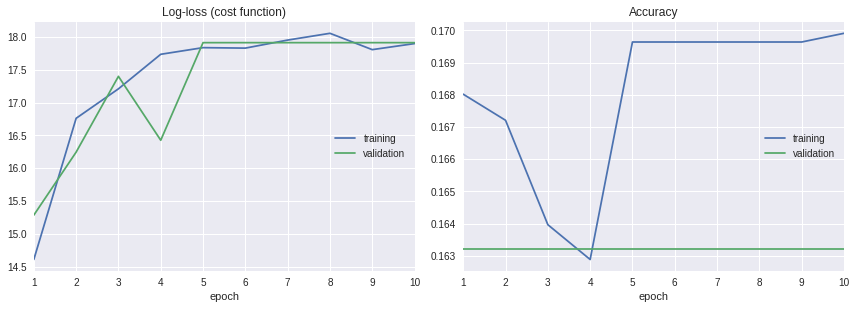

In [0]:
%matplotlib inline
from livelossplot import PlotLossesKeras

batch_size = 32
epochs = 10
history = model_CNN.fit(X_train_gris, y_train_gris,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.3,
                    #validation_data=(X_test_ima, y_test_ima),
                    shuffle=False,
                   callbacks=[PlotLossesKeras()])
#Adagrad

In [0]:
#X_test_transformado = vect.transform(X_test)
y_pred_genres = model_CNN.predict_proba(X_test_gris)
roc_auc_score(y_test_gris, y_pred_genres, average='macro')

0.5

## **Transfer learning**

### NN model

Previously we had loaded the result of VGG16 minus one layer. now we use this output to estimate an NN.
Spliting train a test data sets

In [0]:
from sklearn.model_selection import train_test_split
X_train_ima, X_test_ima, y_train_ima, y_test_ima = train_test_split(images_training_color, y_genres, test_size=0.33, random_state=31415)
print(X_train_ima.shape, X_test_ima.shape, y_train_ima.shape, y_test_ima.shape)

(5289, 5, 5, 512) (2606, 5, 5, 512) (5289, 24) (2606, 24)


In [0]:
X_train_ima.shape[1:]

(5, 5, 512)

The input of the model will be the output of the last layer of VGG16,  then we reshape the data, add a dense layer with tanh activation, finally we add an 24 layer, wich is the disere output for clasification 

In [0]:
drop = 0.4

model_transfer_learning=Sequential()
model_transfer_learning.add(Flatten(input_shape=X_train_ima.shape[1:]))
#model_transfer_learning.add(Dropout(0.2))
model_transfer_learning.add(Dropout(drop))
model_transfer_learning.add(Dense(400, activation='tanh',kernel_initializer = 'RandomNormal'))
#model_transfer_learning.add(Dense(200, activation='tanh',kernel_initializer = 'RandomNormal'))
#model_transfer_learning.add(Dropout(0.5))
#model_transfer_learning.add(Dense(256, activation='tanh',kernel_initializer = 'RandomNormal'))
#model_transfer_learning.add(Dropout(0.5))
#model_transfer_learning.add(Dense(256, activation='tanh',kernel_initializer = 'RandomNormal'))
#model_transfer_learning.add(Dropout(0.5))
#model_transfer_learning.add(Dense(1024, activation='sigmoid',kernel_initializer = 'RandomNormal'))
#model_transfer_learning.add(Dropout(0.3))
#model_transfer_learning.add(Dense(124, activation='sigmoid',kernel_initializer = 'RandomNormal'))
#model_transfer_learning.add(Dense(264, activation='sigmoid'))
#model_transfer_learning.add(Dropout(0.1))
model_transfer_learning.add(Dropout(drop))
model_transfer_learning.add(Dense(24, activation='sigmoid'))
model_transfer_learning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               5120400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                9624      
Total params: 5,130,024
Trainable params: 5,130,024
Non-trainable params: 0
_________________________________________________________________


Compile and fitting model

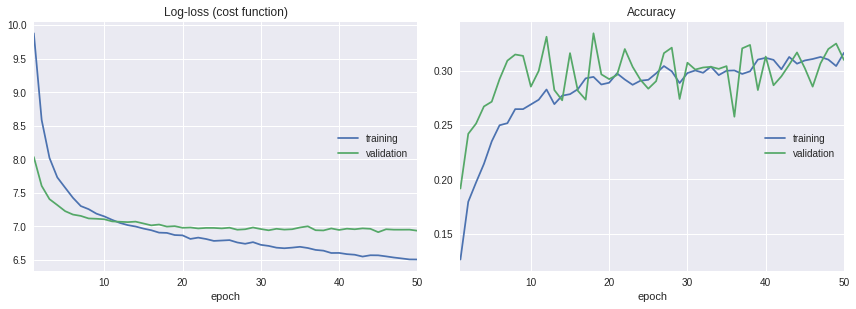

In [0]:
from keras import optimizers
from  livelossplot import PlotLossesKeras
rate=0.0001
model_transfer_learning.compile(
               optimizer=optimizers.SGD(),
               #optimizer=optimizers.SGD(lr = rate),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

epochs=50
batch_size = 50

model_transfer_learning.fit(X_train_ima, y_train_ima,
          epochs=epochs,
          #validation_data=(X_test_ima, y_test_ima),
          shuffle=False,
          #batch_size = batch_size,
          validation_split=0.3,
          callbacks=[PlotLossesKeras()])

In [0]:
#X_test_transformado = vect.transform(X_test)
y_pred_genres = model_transfer_learning.predict_proba(X_test_ima)
roc_auc_score(y_test_ima, y_pred_genres, average='macro')

0.697195068446352

# **Text Model Using NN**

## Sequential Neural Network

Split train and test

In [0]:
X_train_texto, X_test_texto, y_train_genres_texto, y_test_genres_texto = train_test_split(dataTraining['plot']
                                                                  , y_genres, test_size=0.33, random_state=42)

To reorganize the text information, we try many methods, amoung them we can mention Stop words, steemers, ngram, etc.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]


vect = CountVectorizer(ngram_range=(1, 3), max_features=3000, stop_words='english',analyzer=split_into_lemmas)
#bueno vect = CountVectorizer(ngram_range=(1, 3), max_features=3000, stop_words='english')
X_dtm = vect.fit(X_train_texto)
X_train_transformado = vect.transform(X_train_texto)
X_train_transformado.shape
X_test_transformado = vect.transform(X_test_texto)


[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
print(X_train_transformado.shape)
tamano = X_train_transformado.shape[1]


(5289, 3000)


Defining the NN

In [0]:
drop = 0.6

from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation, BatchNormalization
model_text = Sequential()
#128

model_text.add(Dense(128, input_shape=(tamano,),kernel_initializer = 'RandomNormal'))
#model_text.add(LSTM(32))
model_text.add(Activation('sigmoid'))
model_text.add(BatchNormalization())
model_text.add(Dropout(drop))
#50
model_text.add(Dense(50))
model_text.add(Activation('sigmoid'))

model_text.add(Dense(24))

model_text.add(Activation('sigmoid'))

model_text.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               384128    
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                6450      
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1224      
__________

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from keras.optimizers import Adam
lr = 0.1
model_text.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr = lr),
              metrics=['acc']
              #shuffle=False,
          )
#Adagrad
#RMSprop

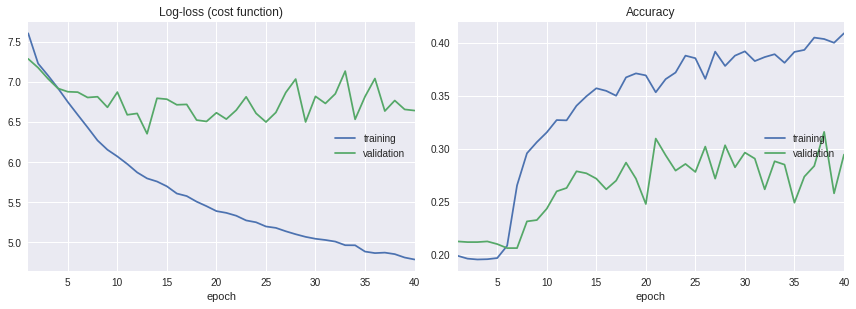

In [0]:
%matplotlib inline

batch_size = 32
epochs = 40
history = model_text.fit(X_train_transformado, y_train_genres_texto,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    #validation_data=(X_test_transformado, y_test_genres_texto),
                    shuffle=False,
                    validation_split=0.3,     
                   callbacks=[PlotLossesKeras()])
#Adagrad

In [0]:

y_pred_genres = model_text.predict_proba(X_test_transformado)
roc_auc_score(y_test_genres_texto, y_pred_genres, average='macro')

0.836065010685077

## ***Recurrent Neural Network***

Defining the vocabulary

In [0]:
X = dataTraining['plot'].tolist()

In [0]:
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

***Embedding***

In [0]:
max_plot_len = 150
X = [x[:max_plot_len] for x in X]

X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [0]:
from keras.preprocessing import sequence
X_pad = sequence.pad_sequences(X, maxlen=max_plot_len)
X_pad

array([[64, 15, 24, ..., 33, 33, 58],
       [ 0,  0,  0, ...,  2, 33, 12],
       [54, 25, 33, ..., 54,  4, 33],
       ...,
       [ 4, 54,  2, ..., 54, 25, 60],
       [64, 14, 24, ..., 35, 67, 66],
       [ 0,  0,  0, ..., 66, 33, 12]], dtype=int32)

In [0]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [0]:
X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(X_pad, y_genres, test_size=0.30, random_state=31415)

The following LSTM neural network is defined:



In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from keras import optimizers

%matplotlib inline

model_rec = Sequential()
model_rec.add(Embedding(len(vocabulary) + 1, 128, input_length=max_plot_len))
model_rec.add(Dropout(0.3))
model_rec.add(LSTM(128, return_sequences = True))
model_rec.add(Dropout(0.3))
model_rec.add(LSTM(64))
model_rec.add(Dropout(0.3))
model_rec.add(Dense(24, activation='sigmoid'))

model_rec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 128)          9600      
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
Total para

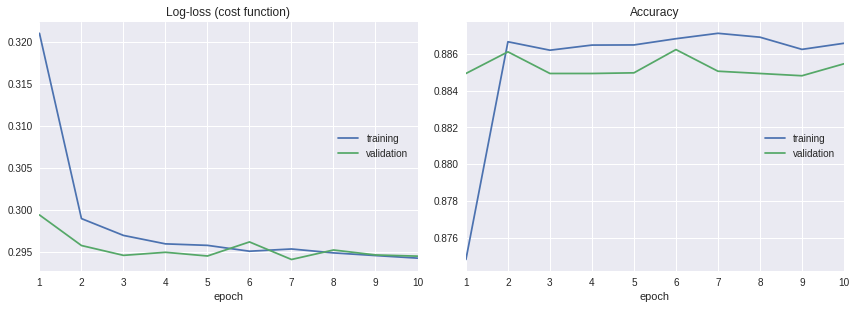

In [0]:
model_rec.compile(optimizer=optimizers.RMSprop(lr = 0.01, decay = 0.01),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model_rec.fit(X_train_rec, y_train_rec, validation_data=[X_test_rec, y_test_rec], epochs=10, batch_size=128,
          callbacks=[PlotLossesKeras()])

In [0]:
ypred_rec=model_rec.predict(X_test_rec)
from sklearn.metrics import roc_auc_score

print('ROC',roc_auc_score(y_test_rec,ypred_rec,average='macro'))

ROC 0.4908896180766207


# **Both text and image Models**

## Average

Before trying more complex models, we simply predict a probability using images, then using text and average the two

In [0]:
from sklearn.model_selection import train_test_split
X_train_ima, X_test_ima, y_train_ima, y_test_ima, X_train_texto, X_Test_texto = train_test_split(images_training_color, y_genres,dataTraining['plot'], test_size=0.33, random_state=31415)
print(X_train_ima.shape, X_test_ima.shape, y_train_ima.shape, y_test_ima.shape,X_train_texto.shape, X_Test_texto.shape)

(5289, 5, 5, 512) (2606, 5, 5, 512) (5289, 24) (2606, 24) (5289,) (2606,)


In [0]:
X_test_transformado = vect.transform(X_Test_texto)

Prediccion_texto = model_text.predict_proba(X_test_transformado)
#Prediccion_texto = model_rec.predict_proba(X_test_transformado)
Prediccion_imagen = model_transfer_learning.predict_proba(X_test_ima)
print("tamano texto", Prediccion_texto.shape)
print("tamano imagen", Prediccion_imagen.shape)
union_promedio = (Prediccion_texto + Prediccion_imagen)/2

roc_auc_score(y_test_ima, union_promedio, average='macro')



tamano texto (2606, 24)
tamano imagen (2606, 24)


0.9064210988362754

Exporting results in kaggle competition format

In [0]:

#x_kaggle_avg = np.concatenate((model_text.predict_proba(vect.transform(dataTesting['plot'])), model_transfer_learning.predict_proba(images_test_vgg)), axis=1)
y_pred_avg = (model_text.predict_proba(vect.transform(dataTesting['plot'])) + model_transfer_learning.predict_proba(images_testing_color))/2
#X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#y_pred_test_genres = model.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_avg, index=dataTesting.index, columns=cols).to_csv('pred_genres_kaggle_model_avg.csv', index_label='ID')
#kaggle = pd.DataFrame(y_pred_kaggle_model, index=dataTesting.index, columns=cols)

In [0]:
#from google.colab import files
#files.kaggle('20180720_model_union.csv')

from google.colab import files

#kaggle.to_csv('pred_genres_kaggle_model_nn_union.csv')
files.download('pred_genres_kaggle_model_avg.csv')

## Neural network for both models output

The output of the image model attached to the output of the text model, become the input of a NN

In [0]:
#x_train_union = pd.concat([Prediccion_texto, Prediccion_imagen], axis=1)
#x_train_union = np.stack((Prediccion_texto, Prediccion_imagen))
train_prediccion_texto = model_text.predict_proba(vect.transform(X_train_texto))
train_prediccion_imagen = model_transfer_learning.predict_proba(X_train_ima)
x_train_union = np.concatenate((train_prediccion_texto, train_prediccion_imagen), axis=1)
print(x_train_union.shape)


train_prediccion_texto = model_text.predict_proba(vect.transform(X_Test_texto))
train_prediccion_imagen = model_transfer_learning.predict_proba(X_test_ima)
x_test_union = np.concatenate((train_prediccion_texto, train_prediccion_imagen), axis=1)
print(x_test_union.shape)
shape_pred = x_train_union.shape[1]




(5289, 48)
(2606, 48)


In [0]:
model_union_predict_input = Sequential()
#128
model_union_predict_input.add(Dense(24, input_shape=(shape_pred,),kernel_initializer = 'RandomNormal'))
model_union_predict_input.add(Activation('sigmoid'))
#model_union_predict_input.add(BatchNormalization())
#model_union_predict_input.add(Dropout(0.1))
#50
#model_union_predict_input.add(Dense(50))
#model_union_predict_input.add(Activation('sigmoid'))

model_union_predict_input.add(Dense(24))

model_union_predict_input.add(Activation('sigmoid'))

model_union_predict_input.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 24)                1176      
_________________________________________________________________
activation_11 (Activation)   (None, 24)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
_________________________________________________________________
activation_12 (Activation)   (None, 24)                0         
Total params: 1,776
Trainable params: 1,776
Non-trainable params: 0
_________________________________________________________________


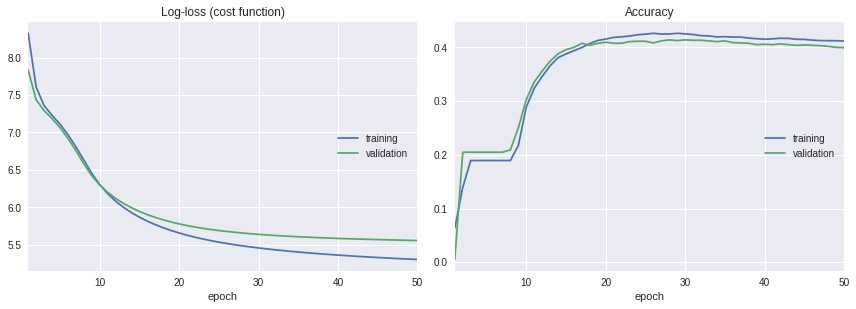

In [0]:
rate = 0.1
model_union_predict_input.compile(loss='categorical_crossentropy',
              #optimizer=RMSprop(),
              #optimizer=Adagrad(),     
              optimizer=Adam(),                         
              #optimizer=SGD(lr = lr),                    
              #optimizer=SGD(),
              metrics=['acc']
              #shuffle=False,
          )
#Adagrad
#RMSprop
#SGD
#%matplotlib inline

batch_size = 32
epochs = 50
history = model_union_predict_input.fit(x_train_union, y_train_ima,
                    #batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    #validation_data=(x_test_union, y_test_ima),
                    shuffle=False,
                    validation_split=0.3,
                   callbacks=[PlotLossesKeras()])

In [0]:
y_pred_genres = model_union_predict_input.predict_proba(x_test_union)
roc_auc_score(y_test_ima, y_pred_genres, average='macro')

0.8845518187637075

In [0]:

x_kaggle_union = np.concatenate((model_text.predict_proba(vect.transform(dataTesting['plot'])), model_transfer_learning.predict_proba(images_testing_color)), axis=1)
y_pred_kaggle_model = model_union_predict_input.predict_proba(x_kaggle_union)
#X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#y_pred_test_genres = model.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_kaggle_model, index=dataTesting.index, columns=cols).to_csv('pred_genres_kaggle_model_nn_union.csv', index_label='ID')
#kaggle = pd.DataFrame(y_pred_kaggle_model, index=dataTesting.index, columns=cols)

In [0]:
#from google.colab import files
#files.kaggle('20180720_model_union.csv')

from google.colab import files

#kaggle.to_csv('pred_genres_kaggle_model_nn_union.csv')
files.download('pred_genres_kaggle_model_nn_union.csv')

## NN with two types of inputs

Now we try to build a model which has two types of inputs, image and text, the NN will estimate the parameters using both inptus at the same time

In [0]:
from sklearn.model_selection import train_test_split

X_train_ima, X_test_ima, y_train, y_test, X_train_text, X_test_text = train_test_split(images_training_color, y_genres, dataTraining['plot'], test_size=0.33, random_state=31415)
print(X_train_ima.shape, X_test_ima.shape, y_train.shape, y_test.shape, X_train_text.shape,X_test_text.shape )


(5289, 5, 5, 512) (2606, 5, 5, 512) (5289, 24) (2606, 24) (5289,) (2606,)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import nltk
nltk.download('wordnet')
#wordnet_lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    #return [wordnet_lemmatizer.lemmatize(word) for word in words]
    return [stemmer.stem(word) for word in words]


#vect = TfidfVectorizer(ngram_range=(1, 4), max_features=3000)
#vect = TfidfVectorizer(ngram_range=(1, 4), max_features=3000,analyzer=split_into_lemmas)#ganador temporal 
vect = TfidfVectorizer(ngram_range=(1, 4), max_features=3000,analyzer=split_into_lemmas)
#vect = TfidfVectorizer(ngram_range=(1, 5), max_features=2000,analyzer=split_into_lemmas, min_df=2, stop_words='english')
#vect = TfidfVectorizer(ngram_range=(1, 3), max_features=3000, stop_words='english',analyzer=split_into_lemmas)
#bueno vect = CountVectorizer(ngram_range=(1, 3), max_features=3000, stop_words='english')
vect = vect.fit(X_train_text)
X_train_transformado = vect.transform(X_train_text)
X_train_transformado.shape
X_test_transformado = vect.transform(X_test_text)


[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
import numpy as np
import pandas as pd
import keras
import keras
from keras.layers import Input, Dense, concatenate, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalMaxPool2D
from keras.models import Model
from matplotlib import pyplot as plt
from scipy.ndimage import rotate as rot

Input_image = Input(shape=(5,5,512), name='input1')
X_train_transformado = vect.transform(X_train_text)
tam_texto = X_train_transformado.shape[1:]
print (X_train_transformado.shape[1:])
Input_text = Input(shape=tam_texto, name = 'input2')

(3000,)


the we define the model, at the middle  of the construction, we add the second input which is the text data

In [0]:
drop_1 = 0.5
drop_2 = 0.5

x = Flatten()(Input_image)
#x = BatchNormalization()(x)

x = Dense(1000,kernel_initializer = 'RandomNormal')(x)
x = Activation('tanh')(x)
x = Dropout(drop_1)(x)
#200 mejor
x = Dense(200)(x)
x = Activation('tanh')(x)
x = Dropout(drop_1)(x)
#x = Dense(500)(x)
#x = Activation('sigmoid')(x)
#x = Dropout(drop_1)(x)
#x = Dense(100)(x)
#x = Activation('sigmoid')(x)
#x = Dropout(drop_1)(x)
#x = BatchNormalization()(x)
#x = Activation('tanh')(x)
x = BatchNormalization()(x)
#x = Dropout(drop_1)(x)
#x = Dense(100)(x)
#x = Dense(24)(x)
#x = Activation('tanh')(x)



#x = GlobalMaxPool2D()(x)
#1000,500 ganador temporal
y = Dense(1000,kernel_initializer = 'RandomNormal')(Input_text)
y = Activation('tanh')(y)
y = Dropout(drop_1)(y)
y = Dense(200)(y)
y = Activation('tanh')(y)
y = Dropout(drop_1)(y)
#y = Dense(500)(y)
#y = Activation('sigmoid')(y)
#y = Dropout(drop_1)(y)
#y = Dense(100)(y)
#y = Activation('sigmoid')(y)
#y = Dropout(drop_1)(y)
y = BatchNormalization()(y)

#y = Dropout(drop_2)(y)
#y = Dense(50)(y)
#y = Activation('sigmoid')(y)
#y = BatchNormalization()(y)
#concatenate text
x = concatenate([x, y])
#128
x = Dense(1000,kernel_initializer = 'RandomNormal')(x)
x = Activation('tanh')(x)
x = Dropout(0.5)(x)
x = Dense(200)(x)
x = Activation('tanh')(x)
x = Dropout(0.2)(x)

#x = Activation('sigmoid')(x)
#x = BatchNormalization()(x)
#x = Dropout(drop_2)(x)
#x = Dense(50)(x)
#x = Dropout(drop_2)(x) # estoy poniendo esta linea
#x = BatchNormalization()(x)
#x = Activation('sigmoid')(x)

#x = Dense(24)(x)
#x = Activation('sigmoid')(x)
out = Dense(24, activation='sigmoid')(x)



In [0]:
model = Model(inputs=[Input_image, Input_text ], outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 5, 5, 512)    0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 12800)        0           input1[0][0]                     
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 3000)         0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 1000)         12801000    flatten_4[0][0]                  
__________________________________________________________________________________________________
dense_24 (

In [0]:
#print(X_train_ima.shape, X_test_ima.shape, y_train.shape, y_test.shape, X_train_text.shape,X_test_text.shape )

from keras import optimizers
from  livelossplot import PlotLossesKeras
#default sgd = 0.01
rate=0.02
model.compile(
               #optimizer=optimizers.RMSprop(),
               optimizer=optimizers.SGD(lr = 0.02),
               #optimizer=optimizers.SGD(lr = rate),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


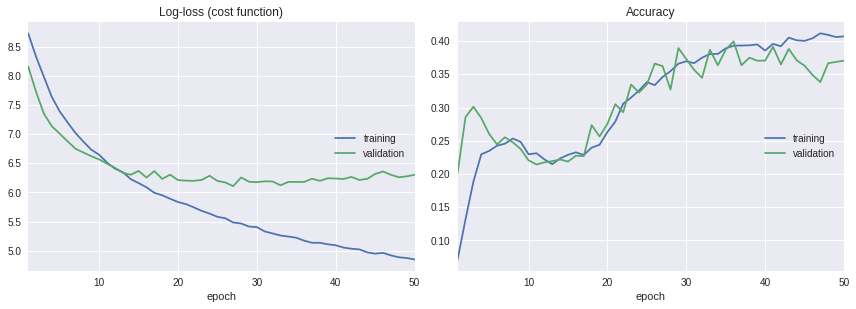

In [0]:

epochs=50
batch_size = 34

model.fit([X_train_ima, X_train_transformado ], y_train,
          epochs=epochs,
          #validation_data=(X_test_ima, y_test_ima),
          shuffle=False,
          batch_size = batch_size,
          validation_split=0.3,
          callbacks=[PlotLossesKeras()])

In [0]:
y_pred_genres = model.predict([X_test_ima,vect.transform(X_test_text)])
roc_auc_score(y_test, y_pred_genres, average='macro')


0.8714054197247578

The perfomrance of the model. this time we had to especify two inputs to predict.

In [0]:

y_pred_avg = model.predict([images_testing_color,vect.transform(dataTesting['plot'])])
#X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#y_pred_test_genres = model.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_avg, index=dataTesting.index, columns=cols).to_csv('pred_genres_kaggle_two_inputs_model.csv', index_label='ID')
#kaggle = pd.DataFrame(y_pred_kaggle_model, index=dataTesting.index, columns=cols)

In [0]:
#from google.colab import files
#files.kaggle('20180720_model_union.csv')

from google.colab import files

#kaggle.to_csv('pred_genres_kaggle_model_nn_union.csv')
files.download('pred_genres_kaggle_two_inputs_model.csv')

# Bibliography




1.   Example of Two-Inputs Neural Network using Keras [link](https://www.kaggle.com/hireme/two-inputs-neural-network-using-keras)
2.   Class Applied Deep Learning - Summer 2018 [link](https://github.com/albahnsen/AppliedDeepLearningClass)
3.   CNN for image classification en Keras [link](https://colab.research.google.com/drive/1Z6r82FlQTBXTh3GZCPc9LeZClxFVhcl_#scrollTo=yIcZavuIgJ3q)
1. Keras Documentation [link](https://keras.io/losses/)


